## Deriving rasters from other rasters

It is not uncommon to need to derive one set of rasters from another.  [Raster math](https://rspatial.org/raster/spatial/8-rastermanip.html#) is pretty easy, but sometimes the steps required can be tricky.  This trickiness includes computing a cumulative series, like cumulative SST.

Here we'll make a cumulative series of CHLOR_A values from our monthly 2018 dataset from the Gulf of Maine. There are a number of ways to do this, but we describe here a very simple approach. First we load packages from our library, then we load our database and filter it to just monthly CHLOR_A in 2018.

In [3]:
library(raster, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

# we only need to install these packages if you don't have them already
# rgdal is used to support geospatial data I/O
installed_packages_names <- rownames(installed.packages())
if (!"ohwobpg" %in% installed_packages_names) remotes::install_github("BigelowLab/ohwobpg", force = TRUE, quiet = TRUE)
if (!"rgdal" %in% installed_packages_names) install.packages("rgdal")

In [4]:
# Load ohwobpg package
library(ohwobpg, warn.conflicts = FALSE)


path <- system.file("gom", package = "ohwobpg")
db <- read_database(path) %>%
  dplyr::filter(per == 'MO' &
                param == 'chlor_a')
db

date,year,mmdd,mit,lvl,per,suite,param,res,nrt,file
<date>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>
2018-01-01,2018,0101,AQUA_MODIS,L3m,MO,CHL,chlor_a,9km,NA,AQUA_MODIS.20180101_20180131.L3m.MO.CHL.chlor_a.9km
2018-02-01,2018,0201,AQUA_MODIS,L3m,MO,CHL,chlor_a,9km,NA,AQUA_MODIS.20180201_20180228.L3m.MO.CHL.chlor_a.9km
2018-03-01,2018,0301,AQUA_MODIS,L3m,MO,CHL,chlor_a,9km,NA,AQUA_MODIS.20180301_20180331.L3m.MO.CHL.chlor_a.9km
2018-04-01,2018,0401,AQUA_MODIS,L3m,MO,CHL,chlor_a,9km,NA,AQUA_MODIS.20180401_20180430.L3m.MO.CHL.chlor_a.9km
2018-05-01,2018,0501,AQUA_MODIS,L3m,MO,CHL,chlor_a,9km,NA,AQUA_MODIS.20180501_20180531.L3m.MO.CHL.chlor_a.9km
2018-06-01,2018,0601,AQUA_MODIS,L3m,MO,CHL,chlor_a,9km,NA,AQUA_MODIS.20180601_20180630.L3m.MO.CHL.chlor_a.9km
2018-07-01,2018,0701,AQUA_MODIS,L3m,MO,CHL,chlor_a,9km,NA,AQUA_MODIS.20180701_20180731.L3m.MO.CHL.chlor_a.9km
2018-08-01,2018,0801,AQUA_MODIS,L3m,MO,CHL,chlor_a,9km,NA,AQUA_MODIS.20180801_20180831.L3m.MO.CHL.chlor_a.9km
2018-09-01,2018,0901,AQUA_MODIS,L3m,MO,CHL,chlor_a,9km,NA,AQUA_MODIS.20180901_20180930.L3m.MO.CHL.chlor_a.9km


So now we have our 12 records.  Let's read them into a raster stack, `chl`.  Note we use the `as_filename()` function to convert from database to filename.

In [5]:
chl <- raster::stack(as_filename(db, path))

Next we iterate through layers 2 through 12, computing the cumulative sum as we go. Afterwards, we'll give the layers more meaningful names.

In [6]:
for (i in seq(from = 2, to = raster::nlayers(chl))){
  chl[[i]] <- chl[[i]] + chl[[i-1]]
}
names(chl) <- format(db$date, "%b")
chl

class      : RasterStack 
dimensions : 86, 110, 9460, 12  (nrow, ncol, ncell, nlayers)
resolution : 0.08333323, 0.08333309  (x, y)
extent     : -72.08333, -62.91667, 38.91668, 46.08332  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
names      :       Jan,       Feb,       Mar,       Apr,       May,       Jun,       Jul,       Aug,       Sep,       Oct,       Nov,       Dec 
min values : 0.1072876, 0.2744358, 0.4042848, 0.5471769, 0.6723558, 0.7843452, 0.9110180, 1.0546749, 1.1297481, 1.2382490, 1.5859103, 2.0285563 
max values :  18.15076,  35.19807,  38.61337, 113.19064, 133.82728, 138.45590, 143.73620, 164.21153, 205.44648, 225.69803, 236.44655, 208.60132 


Now we can do a simple plot for all 12 months.  Note how missing data data propagates forward in time. We'll use the [rasterVis](https://CRAN.R-project.org/package=rasterVis) package to draw, but if it isn't installed we'll just do a simple base-R plot that is similar.

(Tough break, you don't have rasterVis.  Using base graphics... yawn
)

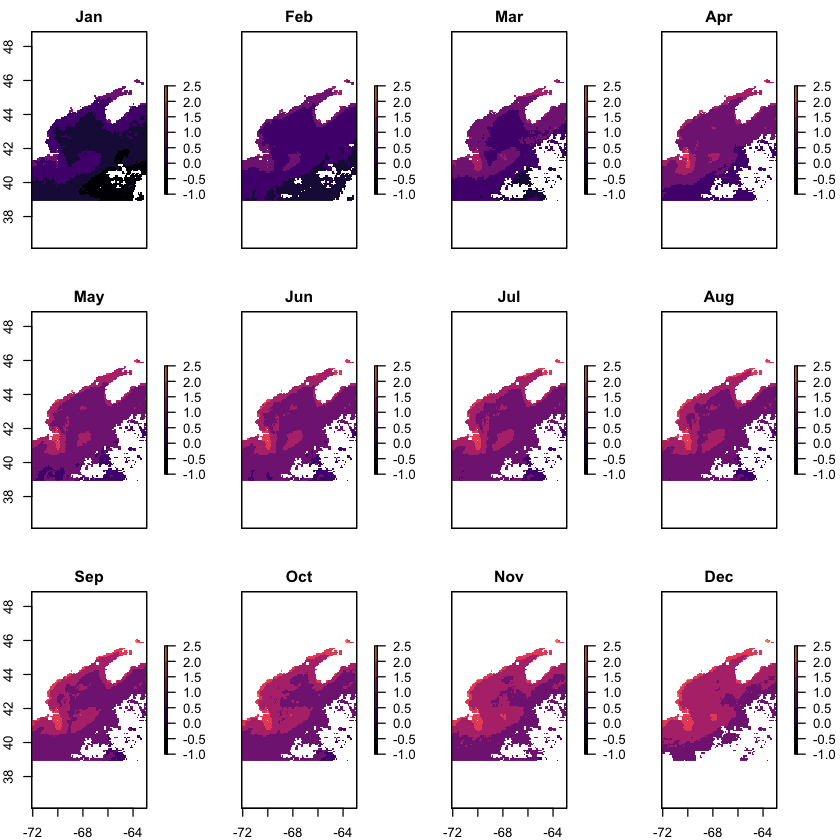

In [9]:
installed <- rownames(installed.packages())
if ("rasterVis" %in% installed){
  cat("(Nice - you have rasterVis!\n)")
  rasterVis::levelplot(log10(chl))
} else {
  cat("(Tough break, you don't have rasterVis.  Using base graphics... yawn\n)")
  breaks <- seq(from = -1, to = 2.5, by = 0.5)
  # adapted from the [viridisLite]() package
  # pal <- viridisLite::magma(length(breaks) - 1)
  pal <- c("#000004FF", "#1D1147FF", "#51127CFF", "#822681FF", "#B63679FF",
           "#E65164FF", "#FB8861FF", "#FEC287FF", "#FCFDBFFF")
  plot(log10(chl), col = pal, breaks = breaks)
}